## Exercício Desafiador: Detecção de Diabetes com Classificadores Supervisionados

## Objetivo
Desenvolver um sistema completo de classificação para prever o diagnóstico de diabetes em mulheres de origem indígena Pima, com base em variáveis clínicas. O exercício envolve desde a preparação dos dados até a avaliação comparativa de diversos modelos.


#### **Base utilizada:** *Pima Indians Diabetes Database*
Dataset disponível aqui no repositório.

### Dicionário de Atributos (Traduzido)
| Atributo | Descrição |
|----------|-----------|
| `preg` | Número de gestações |
| `plas` | Concentração de glicose na hora do teste oral de glicose |
| `pres` | Pressão arterial diastólica (mm Hg) |
| `skin` | Espessura da dobra cutânea do tríceps (mm) |
| `insu` | Nível de insulina sérica (mu U/ml) |
| `mass` | Índice de massa corporal (IMC) |
| `pedi` | Função pedigree do diabetes (histórico familiar) |
| `age` | Idade (anos) |
| `class` | Diagnóstico (0 = negativo, 1 = positivo para diabetes) |

**Responder às perguntas a seguir**
   - Qual modelo teve o melhor **recall**? Por que isso é importante para diagnóstico?
   - Houve modelo com alto **precision**, mas baixo **recall**? O que isso representa?
   - Qual modelo teve o melhor equilíbrio geral (F1-score)?
   - Qual modelo você recomendaria para ser usado em produção hospitalar?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = "/content/drive/MyDrive/DATA_SCIENCE"

Mounted at /content/drive


In [96]:
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
]

df = pd.read_csv(path + '/diabetes.csv', sep=',')

cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
df.isnull().sum()

df_clean = df.dropna(inplace=False)

X = df_clean.drop(columns=['Outcome'])  # remove Insulin (alvo) e Outcome (classificação)



y = df_clean['Outcome']

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Analisando a correlação dos dados e Data Cleaning

In [97]:
# Dataframe com dos dados nulos removidos
df_clean = df.dropna(inplace=False)

# Select only numerical features for correlation analysis
numerical_df = df_clean.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr = numerical_df.corr()

# Display the correlation matrix
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.198291,0.213355,0.093209,0.078984,-0.025347,0.007562,0.679608,0.256566
Glucose,0.198291,1.000000,0.210027,0.198856,0.581223,0.209516,0.140180,0.343641,0.515703
BloodPressure,0.213355,0.210027,1.000000,0.232571,0.098512,0.304403,-0.015971,0.300039,0.192673
SkinThickness,0.093209,0.198856,0.232571,1.000000,0.182199,0.664355,0.160499,0.167761,0.255936
Insulin,0.078984,0.581223,0.098512,0.182199,1.000000,0.226397,0.135906,0.217082,0.301429
BMI,-0.025347,0.209516,0.304403,0.664355,0.226397,1.000000,0.158771,0.069814,0.270118
DiabetesPedigreeFunction,0.007562,0.140180,-0.015971,0.160499,0.135906,0.158771,1.000000,0.085029,0.209330
Age,0.679608,0.343641,0.300039,0.167761,0.217082,0.069814,0.085029,1.000000,0.350804
Outcome,0.256566,0.515703,0.192673,0.255936,0.301429,0.270118,0.209330,0.350804,1.000000


In [98]:
#Remover dados nulos
#df.dropna(inplace=True)

In [99]:
# Dataframe com dos dados nulos removidos
df_clean = df.dropna(inplace=False)

# Padronização de dados

In [100]:
# Padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [101]:
print(X_scaled)

[[-0.7174265  -1.09104581 -0.37365481 ... -0.710421   -1.03187632
  -0.9682991 ]
 [-1.02921274  0.46631407 -2.45696436 ...  1.42673006  5.11511079
   0.2095853 ]
 [-0.09385402 -1.44794079 -1.65569146 ... -0.29723846 -0.79712575
  -0.47751393]
 ...
 [-0.40564026 -1.12349081 -1.01467313 ... -0.66767798  0.70411863
  -0.87014206]
 [ 2.08864966 -0.70170584  0.42761809 ... -0.02653266 -1.0202837
   3.15429628]
 [ 0.52971846 -0.05280589  0.10710893 ... -0.9811268  -0.80582021
  -0.0848858 ]]


# Separar treino e teste

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Algoritmos de Classificação

In [103]:
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=200),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf'),
    "K-NN": KNeighborsClassifier(n_neighbors=5)
}

# Avaliação por modelo


 Regressão Logística
Acurácia : 0.76
Precisão : 0.73
Recall   : 0.71
F1-Score : 0.72


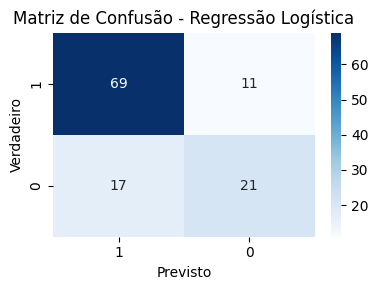


 Árvore de Decisão
Acurácia : 0.69
Precisão : 0.66
Recall   : 0.68
F1-Score : 0.67


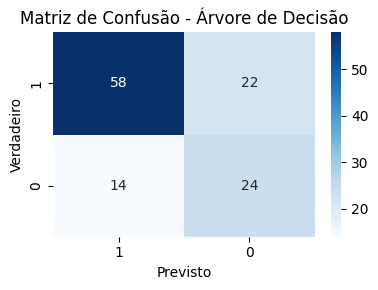


 Random Forest
Acurácia : 0.75
Precisão : 0.72
Recall   : 0.70
F1-Score : 0.71


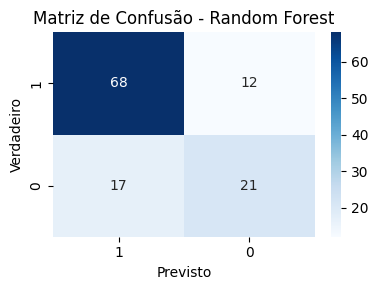


 SVM
Acurácia : 0.73
Precisão : 0.69
Recall   : 0.68
F1-Score : 0.68


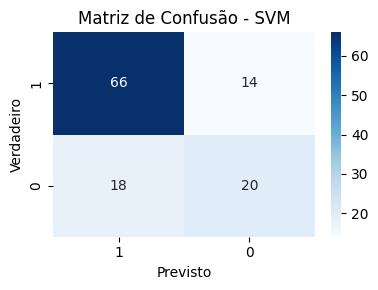


 K-NN
Acurácia : 0.74
Precisão : 0.70
Recall   : 0.70
F1-Score : 0.70


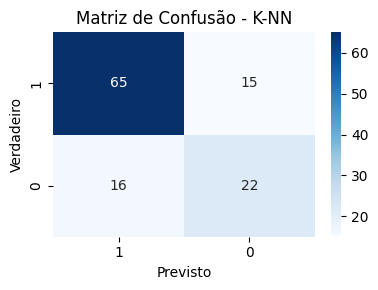

In [105]:
class_names=[1,0]
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n {nome}")
    print(f"Acurácia : {acc:.2f}")
    print(f"Precisão : {prec:.2f}")
    print(f"Recall   : {rec:.2f}")
    print(f"F1-Score : {f1:.2f}")

    # Matriz de confusão
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()

# Qual modelo teve o melhor recall? Por que isso é importante para diagnóstico?

# Houve modelo com alto precision, mas baixo recall? O que isso representa?

# Qual modelo teve o melhor equilíbrio geral (F1-score)?

# Qual modelo você recomendaria para ser usado em produção hospitalar?